## Neural network (with one hidden layer) from scratch ##
#### Purpose of the neural network : 2 class classification ####
### Learning objective: various activation functions, compute cross entropy loss, forward & backward propagation, random initialization ###

### Input Data ###

In [60]:
# Here input data X : has two input features (both are real numbers)
# Y : has two classes 0, 1
# We'll generate X, Y with help of code

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

In [121]:
# function to create data set
# create a flower like structure

def load_planar_dataset(seed=1):
    np.random.seed(seed)
    m = 400 # number of examples
    N = int(m/2) # number of points per class; N=200
    D = 2 # dimensionality; two classes
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))# 0-199; 200-399;
        
        # numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
        # Return evenly spaced numbers over a specified interval
        
        # numpy.random.randn(d0, d1, ..., dn)
        # d0, d1, …, dn : int, optional - The dimensions of the returned array
        # Return a sample (or samples) from the “standard normal” distribution
        
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)] 
        # numpy.c_ Translates slice objects to concatenation along the second axis
        
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [63]:
X, Y = load_planar_dataset()

In [64]:
X.shape # X - the x(i)s are stacked horizontally

(2, 400)

In [65]:
Y.shape # Y - the y(i)s are stacked horizontally

(1, 400)

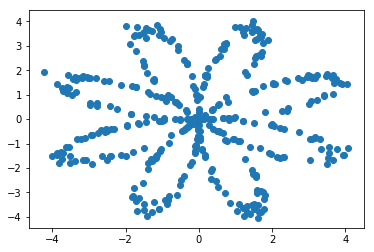

In [66]:
%matplotlib inline
# Visualize the data:
plt.scatter(X[0, :], X[1, :])

In [67]:
# checking some random data
print(X[:,15], Y[:,15], X[:,228], Y[:,228] )

[0.0063551  0.41813177] [0] [-1.68448953 -3.76359366] [1]


### Simple Logistic Regression from Scikit learn - just to compare with NN model to be developed later ###

In [68]:
classifier = sklearn.linear_model.LogisticRegressionCV(); # logisic regression with built is cross validation
classifier.fit(X.T, Y.T); 
# in fit function X should have the dimension (m,nx); Y - (m,)

C:\Users\einchat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\einchat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [69]:
# Print accuracy
LR_predictions = classifier.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


In [70]:
# using an available function ## facing problem with this function

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

### Neural Network Model ###

In [71]:
# we will have the following model

# Input layer - [0] : X = A0 - two input features - so n0=2; A0 - [n0 x m]
# One hidden layer - [1] - n1 hidden units - n1=4 ; Activation function: tanh
# Output layer [2] - n2 unit - n2=1; Activation function: sigmoid

# Parameters for [1]
# W1 - [n1 x n0] = [4 x 2] matrix
# b1 - [n1 x 1] = [4 x 1] matrix

# Parameters for [2]
# W2 - [n2 x n1] = [1 x 4] matrix
# b2 - [n2 x 1] = [1 x 1] matrix

# Forward Pass
# Z1 = W1 x A0 + b1 => [n1 x n0] x [n0 x m] + [n1 x 1] ==> [n1 x m]
# A1 = tanh(Z1) => [n1 x m]
# Z2 = W2 x A1 + b2 => [n2 x n1] x [n1 x m] + [n2 x 1] ==> [n2 x m]
# Yhat= A2 = sigmoid(Z2) => [n2 x m] = [1 x m] -- this is same as dimension of Y

# Cost function
# This is binary classification - so cost function is as follows:
# J = (-1/m)Sum (Y*log(Yhat)+(1-Y)*log(1-Yhat))

# Backward Pass
# dZ2 = A2 - Y; dimension [n2 x m]
# dW2 = (1/m) dZ2 x A1.T ; dim check - [n2 x m] x [m x n1] => [n2 x n1] -- same as W2
# db2 = (1/m) Sum(dZ2, column-wise sum) => [n2 x 1] -- same as b2
# dZ1 = W2.T x dZ2 * g1prime(Z1) => [n1 x n2] x [n2 x m] * [n1 x m] => [n1 x m]; g1prime - derivative of g1 i,e, tanh
# dW1 = (1/m) dZ1 x A0.T; [n1 x m] x [m x n0] => [n1 x n0] -- same as W1
# db1 = (1/m) Sum(dZ1, column-wise sum) => [n1 x 1] -- same as b1

# Update
# W1 = W1 - alpha.dW1 and so on

# What are variables
# n0, n1, n2; 

# Functions to write in order to modularize
# Initialize parameters - arg: n0, n1, n2; function: random initialization of W,b s and return them
# Forward Pass function - arg: A0=X, W, b; function: calculate A2 and J
# Backward Pass function - arg: A2, Y; function: calculate derivatives and update W,b
# Predict function - arg: X_test; function: calculate Yhat_test and return

In [72]:
def initialize_parameters(numberOfLayers, listNumberOfUnits):
    """
    numberOfLayers - int - should include input layer also
    listNumberOfUnits - array of int - units in each layer
    
    Returns:
    a dictionary - parameters for W's and b's
    """
    parameter = {} # start with empty dictionary
    
    for layer in range(1,numberOfLayers):
        print(listNumberOfUnits[layer],listNumberOfUnits[layer-1])
        Wlayer = np.random.randn(listNumberOfUnits[layer], listNumberOfUnits[layer-1]) * 0.01
        blayer = np.zeros((listNumberOfUnits[layer],1))
        parameter["W"+str(layer)] = Wlayer
        parameter["b"+str(layer)] = blayer
    
    return parameter

In [73]:
# test the initialize_parameters function
numberOfLayers = 3 # including input layer
listNumberOfUnits = [2,4,1]
parameter=initialize_parameters(numberOfLayers, listNumberOfUnits)

4 2
1 4


In [74]:
parameter["W1"].shape

(4, 2)

In [75]:
parameter["W2"].shape

(1, 4)

In [76]:
parameter["W2"]

array([[ 0.00209097,  0.01555016, -0.00569149, -0.01061797]])

In [77]:
len(parameter)

4

In [93]:
def forward_pass(X,Y, parameter):
    """
    X - input - dimension [n0 x m]; Note: X=A0; n0=nx;
    Y - ground truth - [nL x m]
    parameter - dictionary - contains W's, b's
    
    Returns:
    activation values - dictionary
    J - cost 
    """
    
    m = X.shape[1]
    numberLayers = int(len(parameter)/2) # this is without input layer - if len(parameter)==10 - then means 5 layers
    A_prev = X
    J = 0
    activation = {} # start with empty dictionary
    activation['0'] = X
    
    for layer in range(1,numberLayers+1): # i.e. 1 to 5
        W = parameter["W" + str(layer)]
        b = parameter["b" + str(layer)]
        #print('layer' + str(layer))
        #print('shape: W')
        #print(W.shape)
        #print('shape: A_prev')
        #print(A_prev.shape)
        Z = np.dot(W,A_prev) + b
        if layer != numberLayers:
            A = activationFunction(Z, 'tanh')
        else:
            A = activationFunction(Z, 'sigmoid')
        activation[str(layer)]= A
        A_prev = A
    
    # at end of iteration, Yhat = A
    
    J = (-1/m)*np.sum( Y*np.log(A) + (1-Y)*np.log(1-A))
    
    return activation,J

In [94]:
# Write the activation function 
# Assumption: hidden layer - tanh activation function; output layer - sigmoid function
def activationFunction(Z, fn='tanh'):
    """
    Z - a matrix
    layer - int - indicating the current layer
    
    Returns:
    result of activation 
    """
    if fn== 'sigmoid':
        # sigmoid
        A = 1/(1+np.exp(-Z))
    else:
        # tanh
        A = (np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
    
    return A

In [95]:
# test activationFunction
activationFunction(0,"sigmoid")

0.5

In [96]:
activationFunction(0,"tanh")

0.0

In [97]:
activationFunction(-10,"tanh")

-0.9999999958776926

In [98]:
# Backward Pass
# dZ2 = A2 - Y; dimension [n2 x m]
# dW2 = (1/m) dZ2 x A1.T ; dim check - [n2 x m] x [m x n1] => [n2 x n1] -- same as W2
# db2 = (1/m) Sum(dZ2, column-wise sum) => [n2 x 1] -- same as b2
# dZ1 = W2.T x dZ2 * g1prime(Z1) => [n1 x n2] x [n2 x m] * [n1 x m] => [n1 x m]; g1prime - derivative of g1 i,e, tanh
### derivative of tanh(Z) = 1- tanh(Z)^2
# dW1 = (1/m) dZ1 x A0.T; [n1 x m] x [m x n0] => [n1 x n0] -- same as W1
# db1 = (1/m) Sum(dZ1, column-wise sum) => [n1 x 1] -- same as b1

# Backward Pass function - arg: A2, Y; function: calculate derivatives and update W,b

def backward_pass(Yhat, Y, parameter, activation, alpha=0.01):
    """"
    Yhat, Y - [nL x m]
    parameter - dictionary containing W's, b's
    activation - dictionary conatining activation values
    
    Returns:
    updated parameters
    """
    
    m = Y.shape[1]
    numberLayers = int(len(parameter)/2) # this is without the input layer
    
    ## shall try the loop based implementation layer
    ## now lets do basic calculation
    dZ2 = Yhat - Y
    dW2 = (1/m)*np.dot(dZ2, activation['1'].T)
    db2 = (1/m)*np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(parameter["W2"].T,dZ2) * (1 - np.power(activation['1'], 2))# g1prime -- tanh-derivative - 1-a^2;
    dW1 = (1/m)* np.dot(dZ1, activation['0'].T)
    db1 = (1/m)* np.sum(dZ1, axis=1, keepdims=True)
    
    parameter['W1'] = parameter['W1'] - alpha* dW1
    parameter['b1'] = parameter['b1'] - alpha* db1
    parameter['W2'] = parameter['W2'] - alpha* dW2
    parameter['b2'] = parameter['b2'] - alpha* db2
    
    return parameter

In [99]:
X.shape

(2, 400)

In [100]:
Y.shape

(1, 400)

In [107]:
## actual running the model
np.random.seed(3)
numberOfIteration = 20000
numberOfLayers = 3
listNumberOfUnits = [2,4,1]
alpha = 1.2
parameter = initialize_parameters(numberOfLayers, listNumberOfUnits)
for i in range(numberOfIteration):
    #print('i '+str(i))
    activation,J = forward_pass(X,Y, parameter)
    if (i%1000==0):
        print('Iteration '+str(i))
        print('Cost' + str(J))
    
    Yhat = activation[str(numberOfLayers-1)]
    parameter = backward_pass(Yhat, Y, parameter, activation, alpha)
    

4 2
1 4
Iteration 0
Cost0.6931621661402946
Iteration 1000
Cost0.25862506828690474
Iteration 2000
Cost0.2393335165458315
Iteration 3000
Cost0.23080163442975746
Iteration 4000
Cost0.2255280270817635
Iteration 5000
Cost0.221844675950227
Iteration 6000
Cost0.21909438354878738
Iteration 7000
Cost0.2206059477385167
Iteration 8000
Cost0.21939415031175855
Iteration 9000
Cost0.21848062185993705
Iteration 10000
Cost0.21773715034491392
Iteration 11000
Cost0.2171129219042612
Iteration 12000
Cost0.21657724801406075
Iteration 13000
Cost0.2161096988101459
Iteration 14000
Cost0.21569602938821353
Iteration 15000
Cost0.2153259648926916
Iteration 16000
Cost0.21499187546572515
Iteration 17000
Cost0.21468794744001402
Iteration 18000
Cost0.2144096488651103
Iteration 19000
Cost0.2141533757143732


In [109]:
print (parameter['W1'])

[[ 14.23170772  -4.10699665]
 [  0.15721204 -10.61130347]
 [ 15.21150097  17.56780148]
 [ 11.24307005 -12.21754247]]


In [110]:
print(parameter['b1'])

[[0.48568691]
 [0.02886921]
 [0.05850066]
 [0.01906178]]


In [112]:
print(parameter['W2'])

[[ -3.5832056  -13.03589833  -6.66198143  11.19409684]]


In [113]:
parameter['b2']

array([[-0.07092283]])

In [114]:
# Predict function - arg: X_test; function: calculate Yhat_test and return
def predict_class(X_test, parameters):
    """
    X - input - dimension [n0 x m]; Note: X=A0; n0=nx;
    parameter - dictionary - contains W's, b's
    
    Returns:
    Yhat - [nL x m] matrix
    """
    
    m = X_test.shape[1]
    numberLayers = int(len(parameter)/2) # this is without input layer - if len(parameter)==10 - then means 5 layers
    A_prev = X_test
    
    for layer in range(1,numberLayers+1): # i.e. 1 to 5
        W = parameter["W" + str(layer)]
        b = parameter["b" + str(layer)]
        Z = np.dot(W,A_prev) + b
        if layer != numberLayers:
            A = activationFunction(Z, 'tanh')
        else:
            A = activationFunction(Z, 'sigmoid')
        A_prev = A
    
    # at end of iteration, Yhat = A
    # Now if probability > 0.5 - we'll classify as 1; otherwise 0
    Yhat = A>0.5
    
    return Yhat    

In [116]:
Predictions = predict_class(X, parameter)

In [117]:
print ('Accuracy: %d' % float((np.dot(Y,Predictions.T) + np.dot(1-Y,1-Predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


#### So this is better than the logistic regression result ####
#### however there is a flaw that we are training and testing on the same generated dataset ####
#### So let us load the dataset by changing the random seed and see ####

In [122]:
X, Y = load_planar_dataset(7)

In [123]:
Predictions = predict_class(X, parameter)

In [124]:
print ('Accuracy: %d' % float((np.dot(Y,Predictions.T) + np.dot(1-Y,1-Predictions.T))/float(Y.size)*100) + '%')

Accuracy: 91%


### End of notebook ###
### Learnings ###
#### Generate data set ####
#### Write initialization, forward, backward, predict functions ####
#### Idea on a simple NN with one hidden layer written from scratch ####


In [125]:
# The above coding is inspired by the deep learning course of Prof. Andrew Ng